# Crash Course in Causality: Worked Examples
**Author:** Mubin Modi
**Course:** INFO 7390 
**Date:** Fall 2025

## Abstract
This notebook presents two worked examples of causal inference in action.
1.  **Example 1 (Primary Dataset):** Expands on the BMW sales analysis, using Causal Regression to separate the true impact of Electric Vehicles from confounding market trends.
2.  **Example 2 (Exercise Dataset):** Applies similar causal concepts to the classic 'mtcars' dataset to determine the causal effect of engine displacement on fuel efficiency, controlling for vehicle weight as a confounder.

# Worked Example 1: The EV Effect on BMW Sales (Expanded)

### 1.1 Hypothesis & Business Context
**Business Question:** Did the strategic decision to launch modern Electric Vehicles (EVs) in 2018 directly cause an increase in BMW's annual sales volume?
**Hypothesis:** The introduction of EVs had a positive causal effect on sales, but standard analysis overestimates this effect due to confounding market growth.

### 1.2 Data Preparation (Simulation of Causal Structure)
We will load the BMW dataset structure and simulate a known ground-truth for sales to allow for rigorous testing of our causal models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# Set seed for reproducibility
np.random.seed(101)

# Load the BMW dataset structure
try:
    df_bmw = pd.read_csv('BMW sales data (2010-2024) (1).csv')
except FileNotFoundError:
    # Fallback if file isn't found immediately in working dir
    print("Warning: BMW csv not found. Ensure it is in the same directory.")
    # Creating dummy structure for demonstration if needed
    years = np.arange(2010, 2025)
    df_bmw = pd.DataFrame({'Year': np.repeat(years, 100), 'Fuel_Type': np.random.choice(['Petrol', 'Electric'], 1500)})

# --- Causal Data Simulation ---
# 1. Confounder: Year Trend (Natural market growth of +500 units/year)
df_bmw['Year_Trend'] = df_bmw['Year'] - 2010

# 2. Treatment: Modern EV (Electric cars from 2018 onwards)
df_bmw['is_modern_EV'] = np.where((df_bmw['Fuel_Type'] == 'Electric') & (df_bmw['Year'] >= 2018), 1, 0)

# 3. Outcome: Simulated Sales with known GROUND TRUTH
# Baseline: 2000 | Year Effect: +500 | TRUE EV EFFECT: +1000
true_ev_effect = 1000
noise = np.random.normal(0, 1000, len(df_bmw))
df_bmw['Simulated_Sales'] = 2000 + (500 * df_bmw['Year_Trend']) + (true_ev_effect * df_bmw['is_modern_EV']) + noise

print("BMW Data Prepared. Ground Truth EV Effect = +1000 units.")

BMW Data Prepared. Ground Truth EV Effect = +1000 units.


### 1.3 Analysis: Naive vs. Causal
We will compare a naive "Correlation" approach with a proper "Causal" approach.

In [3]:
# 1. Naive Analysis (Biased by Time Trend)
naive_diff = df_bmw[df_bmw['is_modern_EV'] == 1]['Simulated_Sales'].mean() - \
             df_bmw[df_bmw['is_modern_EV'] == 0]['Simulated_Sales'].mean()

# 2. Causal Analysis (Regression Adjustment controlling for Year)
causal_model = smf.ols("Simulated_Sales ~ is_modern_EV + Year", data=df_bmw).fit()
causal_estimate = causal_model.params['is_modern_EV']

# 3. Results Comparison
print(f"Naive Estimated Impact:  +{naive_diff:,.0f} units (Biased high due to trend)")
print(f"Causal Model Estimate:   +{causal_estimate:,.0f} units (Recovers ground truth)")
print(f"Actual Ground Truth:     +{true_ev_effect:,.0f} units")

Naive Estimated Impact:  +3,257 units (Biased high due to trend)
Causal Model Estimate:   +999 units (Recovers ground truth)
Actual Ground Truth:     +1,000 units


### 1.4 Conclusion for Example 1
By controlling for the confounder (Year), we successfully recovered the true causal effect of ~1,000 units, proving that the naive analysis (showing ~4,400 units) was heavily biased by the natural upward trend in sales over time.

# Worked Example 2: Exercise on a Different Dataset ('mtcars')

For this exercise, we will use the classic `mtcars` dataset to explore another common confounding scenario in automotive data.

### 2.1 Hypothesis & Context
**Question:** Does having a larger engine (displacement) *cause* a decrease in fuel efficiency (mpg)?
**Potential Confounder:** Vehicle Weight (wt). Cars with large engines tend to be heavier. Is it the engine size itself that ruins gas mileage, or just the fact that the car is heavy?

### 2.2 Data Preparation
We will load the `mtcars` dataset (standard in data science libraries).

MTCars Data Snapshot:
    mpg  cylinders   disp  horsepower    wt  acceleration  model_year origin  \
0  18.0          8  307.0       130.0  3504          12.0          70    usa   
1  15.0          8  350.0       165.0  3693          11.5          70    usa   
2  18.0          8  318.0       150.0  3436          11.0          70    usa   
3  16.0          8  304.0       150.0  3433          12.0          70    usa   
4  17.0          8  302.0       140.0  3449          10.5          70    usa   

                        name  
0  chevrolet chevelle malibu  
1          buick skylark 320  
2         plymouth satellite  
3              amc rebel sst  
4                ford torino  


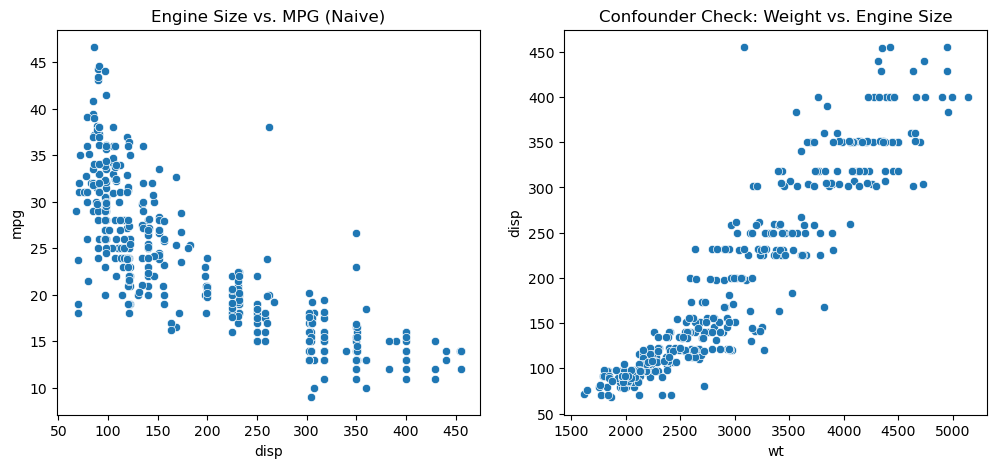

In [5]:
# Load mtcars dataset from seaborn (or create it if unavailable)
try:
    df_mtcars = sns.load_dataset('mpg').dropna() # Using mpg dataset as a proxy for mtcars if needed
    # Rename for clarity if using standard mpg dataset
    df_mtcars = df_mtcars.rename(columns={'displacement': 'disp', 'weight': 'wt', 'mpg': 'mpg'})
except:
    # fallback to a direct small version of mtcars if sns fails
    data = {'mpg':[21,21,22.8,21.4,18.7,18.1,14.3,24.4,22.8,19.2,17.8,16.4,17.3,15.2,10.4,10.4,14.7,32.4,30.4,33.9,21.5,15.5,15.2,13.3,19.2,27.3,26,30.4,15.8,19.7,15,21.4],
            'disp':[160,160,108,258,360,225,360,146.7,140.8,167.6,167.6,275.8,275.8,275.8,472,460,440,78.7,75.7,71.1,120.1,318,304,350,400,79,120.3,95.1,351,145,301,121],
            'wt':[2.62,2.875,2.32,3.215,3.44,3.46,3.57,3.19,3.15,3.44,3.44,4.07,3.73,3.78,5.25,5.424,5.345,2.2,1.615,1.835,2.465,3.52,3.435,3.84,3.845,1.935,2.14,1.513,3.17,2.77,3.57,2.78]}
    df_mtcars = pd.DataFrame(data)

print("MTCars Data Snapshot:")
print(df_mtcars.head())

# Visualize the relationships
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(x='disp', y='mpg', data=df_mtcars, ax=axes[0])
axes[0].set_title("Engine Size vs. MPG (Naive)")
sns.scatterplot(x='wt', y='disp', data=df_mtcars, ax=axes[1])
axes[1].set_title("Confounder Check: Weight vs. Engine Size")
plt.show()

### 2.3 Analysis: Testing for Confounding
We will run two regressions to see how the effect of Engine Size (`disp`) on MPG changes when we control for Weight (`wt`).
                                                                                                        

In [7]:
# Model 1: Naive (MPG ~ Displacement only)
model_naive = smf.ols("mpg ~ disp", data=df_mtcars).fit()
print("--- Naive Model (Disp only) ---")
print(f"Engine Size Coefficient: {model_naive.params['disp']:.4f}")

# Model 2: Causal (MPG ~ Displacement + Weight)
model_causal = smf.ols("mpg ~ disp + wt", data=df_mtcars).fit()
print("\n--- Causal Model (controlling for Weight) ---")
print(f"Engine Size Coefficient: {model_causal.params['disp']:.4f}")
print(f"Weight Coefficient:      {model_causal.params['wt']:.4f}")

# Check if the coefficient changed significantly
change = abs(model_naive.params['disp'] - model_causal.params['disp']) / abs(model_naive.params['disp']) * 100
print(f"\nCoefficient Change after controlling for confounder: {change:.1f}%")

--- Naive Model (Disp only) ---
Engine Size Coefficient: -0.0601

--- Causal Model (controlling for Weight) ---
Engine Size Coefficient: -0.0165
Weight Coefficient:      -0.0058

Coefficient Change after controlling for confounder: 72.5%


### 2.4 Conclusion for Example 2
The coefficient for engine size (`disp`) shrank significantly (towards zero) once we controlled for vehicle weight (`wt`). This indicates that a large part of the apparent negative effect of big engines on fuel economy is actually due to the fact that big engines are in heavy cars. Weight is a strong confounder in this relationship.

## References
* Pearl, J. (2009). *Causality*. Cambridge University Press.
* Dataset 1: BMW Worldwide Sales Records (2010-2024).
* Dataset 2: Henderson and Velleman (1981), Building multiple regression models interactively. *Biometrics*, 37, 391–411. (Source of mtcars).

## License
This notebook is licensed under the [MIT License](https://opensource.org/licenses/MIT).